# Exploring Connecticut Pretrial Inmate data (download 9-8-16)

In [4]:
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import numpy as np
import os

In [25]:
%matplotlib inline

### Data Loading and Exploration

In [6]:
orig_dir = os.getcwd()

'C:\\Users\\Seamus\\Documents\\Data\\CT_detention\\notebooks'

In [86]:
local_path = path.abspath(path.join(path.dirname(orig_dir), 'data', 'raw'))
filename = path.join(local_path, 'detention.csv')
filename

'C:\\Users\\Seamus\\Documents\\Data\\CT_detention\\data\\raw\\detention.csv'

In [87]:
df = pd.read_csv(filename)

In [88]:
df.tail()

,DOWNLOAD DATE,IDENTIFIER,LATEST ADMISSION DATE,RACE,GENDER,AGE,BOND AMOUNT,OFFENSE,FACILITY,DETAINER
261852,10/24/2016,ZZERLBLL,09/14/2016,WHITE,M,50,30250,"FAILURE TO APPEAR, FIRST DEGREE DF",HARTFORD CC,NONE
261853,10/24/2016,ZZRZLSBS,09/15/2016,BLACK,M,47,12500,"ASSAULT, THIRD DEGREE AM",NEW HAVEN CC,NONE
261854,10/24/2016,ZZSEWZCH,05/25/2016,HISPANIC,M,22,150000,CARRYING WEAPON IN A MOTOR VEHICLE F,HARTFORD CC,NONE
261855,10/24/2016,ZZSELLZS,08/29/2016,BLACK,M,23,50000,CARRYING WEAPONS WITHOUT A PERMIT F,NEW HAVEN CC,NONE
261856,10/24/2016,ZZSECZRH,09/21/2016,WHITE,M,46,7000,"STALKING, 2ND DEGREE AM",NEW HAVEN CC,NONE


In [14]:
pandas_profiling.ProfileReport(df)

Number of variables,10
Number of observations,237896
Total Missing (%),0.0%
Total size in memory,18.2 MiB
Average record size in memory,80.0 B
Numeric,2
Categorical,8
Date,0
Text (Unique),0
Rejected,0
Distinct count,62


### Data Cleaning & Preparation

For survival analysis, we are going to want a table with each inmate's unique identifier, information, duration, and whether they are censored (has the event been observed?). 

In [89]:
df = df.rename(columns = lambda x: x.strip())
df = df.drop_duplicates()
df['DOWNLOAD DATE'] = pd.to_datetime(df['DOWNLOAD DATE'])
df['LATEST ADMISSION DATE'] = pd.to_datetime(df['LATEST ADMISSION DATE'])

#### Clear out all inmates that were present on 7-01-16

There is too much noise in the system by using the 'latest admission date' field. Documentation says as much. So we will only include those that had a latest admission date greater than or equal to 07-01-2016. 

In [90]:
df.columns

Index(['DOWNLOAD DATE', 'IDENTIFIER', 'LATEST ADMISSION DATE', 'RACE',
       'GENDER', 'AGE', 'BOND AMOUNT', 'OFFENSE', 'FACILITY', 'DETAINER'],
      dtype='object')

In [91]:
new_df = df[df['LATEST ADMISSION DATE']>='2016-07-01']

In [92]:
demos = new_df.sort_values(by='DOWNLOAD DATE').groupby('IDENTIFIER', as_index=False).first()

In [93]:
from datetime import date, timedelta
yesterday = date.today() - timedelta(1)
agg_df = new_df.groupby('IDENTIFIER', as_index=False)['DOWNLOAD DATE'].agg({'min': np.min, 
                                                                            'max': np.max, 
                                                                            'duration': lambda x: np.max(x) - np.min(x),
                                                                            'observed': lambda x: np.max(x) < (pd.to_datetime('today'))})

In [94]:
agg_df['month'] = pd.DatetimeIndex(agg_df['min']).month

In [95]:
final = demos.merge(agg_df)

In [96]:
final[final['IDENTIFIER']=='ZZECECZW']

,IDENTIFIER,DOWNLOAD DATE,LATEST ADMISSION DATE,RACE,GENDER,AGE,BOND AMOUNT,OFFENSE,FACILITY,DETAINER,observed,duration,max,min,month
45,ZZECECZW,2016-08-13,2016-08-12,BLACK,F,46,7500,PROSTITUTION AM,YORK CI,NONE,True,6 days,2016-08-19,2016-08-13,8


#### Ideas

Does age ever change during detention? Can we see how many people have birthdays in jail?

## Survival Analysis

In [97]:
T = (final['duration'] / np.timedelta64(1,'D')).astype(int)
C = final['observed'].astype(int)

In [98]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=C)

<lifelines.KaplanMeierFitter: fitted with 4608 observations, 2145 censored>

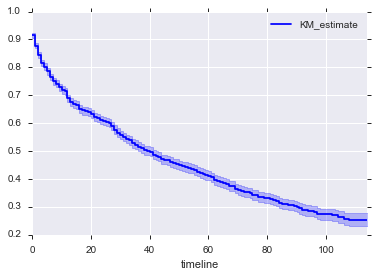

In [99]:
kmf.plot()

In [100]:
kmf.median_

40.0

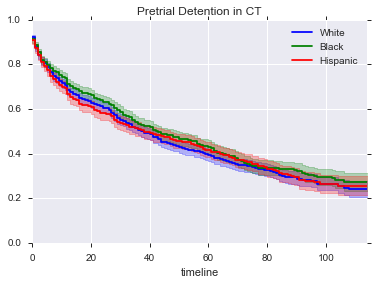

In [101]:
ax = plt.subplot(111)

white = (final['RACE'] == 'WHITE')
black = (final['RACE'] == 'BLACK')
hispanic = (final['RACE'] == 'HISPANIC')
kmf.fit(T[white], event_observed=C[white], label = 'White')
kmf.plot(ax=ax)
kmf.fit(T[black], event_observed=C[black], label = 'Black')
kmf.plot(ax=ax)
kmf.fit(T[hispanic], event_observed=C[hispanic], label = 'Hispanic')
kmf.plot(ax=ax)

plt.ylim(0,1);
plt.title('Pretrial Detention in CT')

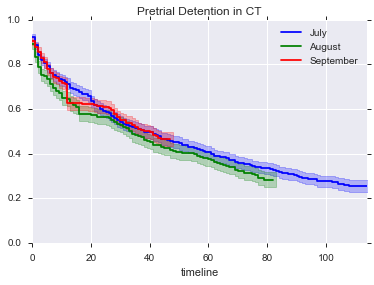

In [102]:
ax = plt.subplot(111)

july = (final['month'] == 7)
aug = (final['month'] == 8)
sept = (final['month'] == 9)
kmf.fit(T[july], event_observed=C[july], label = 'July')
kmf.plot(ax=ax)
kmf.fit(T[aug], event_observed=C[aug], label = 'August')
kmf.plot(ax=ax)
kmf.fit(T[sept], event_observed=C[sept], label = 'September')
kmf.plot(ax=ax)

plt.ylim(0,1);
plt.title('Pretrial Detention in CT')

In [ ]:
# Let's look at the bond amount. Does a low bond help outcomes?

In [103]:
final['lowbond'] = (final['BOND AMOUNT']<1000)

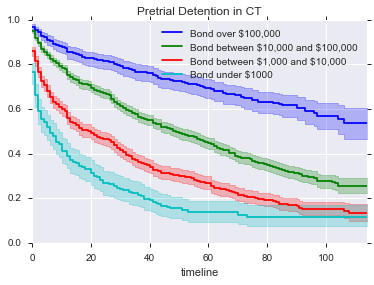

In [107]:
lowbond = (final['BOND AMOUNT']<=1000)
midbond = (final['BOND AMOUNT']>1000)&(final['BOND AMOUNT']<=10000)
highmidbond = (final['BOND AMOUNT']>10000)&(final['BOND AMOUNT']<=100000)
highbond = (final['BOND AMOUNT']>100000)
ax = plt.subplot(111)

kmf.fit(T[highbond], event_observed=C[highbond], label = 'Bond over $100,000')
kmf.plot(ax=ax)
kmf.fit(T[highmidbond], event_observed=C[highmidbond], label = 'Bond between \$10,000 and \$100,000')
kmf.plot(ax=ax)
kmf.fit(T[midbond], event_observed=C[midbond], label = 'Bond between \$1,000 and \$10,000')
kmf.plot(ax=ax)
kmf.fit(T[lowbond], event_observed=C[lowbond], label = 'Bond under $1000')
kmf.plot(ax=ax)

plt.ylim(0,1);
plt.title('Pretrial Detention in CT')

So there are inmates being detained for more than 3 months with a bond under $1000... let's take a look at that population

In [121]:
final[(final['BOND AMOUNT'] <1000)& (T>90)]

,IDENTIFIER,DOWNLOAD DATE,LATEST ADMISSION DATE,RACE,GENDER,AGE,BOND AMOUNT,OFFENSE,FACILITY,DETAINER,observed,duration,max,min,month,lowbond
2365,ZZRLRRWB,2016-07-02,2016-07-01,HISPANIC,M,39,495,"FAILURE TO APPEAR, SECOND DEGREE AM",BRIDGEPORT CC,NONE,False,114 days,2016-10-24,2016-07-02,7,True
3035,ZZSEEWHJ,2016-07-12,2016-07-11,BLACK,M,19,500,"FAILURE TO APPEAR, SECOND DEGREE AM",BRIDGEPORT CC,NONE,False,104 days,2016-10-24,2016-07-12,7,True
4006,ZZSEWCSW,2016-07-06,2016-07-05,WHITE,M,35,500,AFFIRMATIVE DEFENSES TO CIMINAL TRESPASS,BRIDGEPORT CC,NONE,False,110 days,2016-10-24,2016-07-06,7,True
4179,ZZSEZREL,2016-07-21,2016-07-20,WHITE,M,26,500,"BURGLARY, THIRD DEGREE WITH FIREARM DF",NEW HAVEN CC,NONE,False,95 days,2016-10-24,2016-07-21,7,True


In [108]:
final['OFFENSE'].value_counts()

VIOLATION OF PROBATION OR COND DISCHG       880
CRIM VIOL OF PROTECTIVE ORDER         DF    269
FAILURE TO APPEAR, SECOND DEGREE      AM    219
INJURY OR RISK OF INJURY TO MINOR      F    188
BURGLARY, THIRD DEGREE                DF    172
ASSAULT, THIRD DEGREE                 AM    165
FAILURE TO APPEAR, FIRST DEGREE       DF    147
INTERFERING WITH AN OFFICER           AM    138
POSSESSION OF NARCOTICS                     108
THREATENING                           AM    103
SALE OF NARC/AMPHET BY NON-DEPENDENT   F     91
ARREST WITHOUT WARRANT                       80
ASSAULT, SECOND DEGREE                DF     75
BREACH OF PEACE                       BM     69
LARCENY, THIRD DEGREE                 DF     67
LARCENY, SIXTH DEGREE                 CM     64
ROBBERY, FIRST DEGREE                 BF     55
DISORDERLY CONDUCT                    CM     53
ASSAULT ON POLICE OR FIRE OFFICER     CF     51
LARCENY, SECOND DEGREE                CF     50
OPERATE UNDER INFLU OF LIQ OR DRUGS     

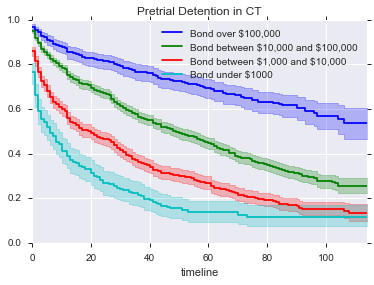

In [109]:
midbond = (final['BOND AMOUNT']>1000)&(final['BOND AMOUNT']<=10000)
highmidbond = (final['BOND AMOUNT']>10000)&(final['BOND AMOUNT']<=100000)
highbond = (final['BOND AMOUNT']>100000)
ax = plt.subplot(111)

kmf.fit(T[highbond], event_observed=C[highbond], label = 'Bond over $100,000')
kmf.plot(ax=ax)
kmf.fit(T[highmidbond], event_observed=C[highmidbond], label = 'Bond between \$10,000 and \$100,000')
kmf.plot(ax=ax)
kmf.fit(T[midbond], event_observed=C[midbond], label = 'Bond between \$1,000 and \$10,000')
kmf.plot(ax=ax)
kmf.fit(T[lowbond], event_observed=C[lowbond], label = 'Bond under $1000')
kmf.plot(ax=ax)

plt.ylim(0,1);
plt.title('Pretrial Detention in CT')

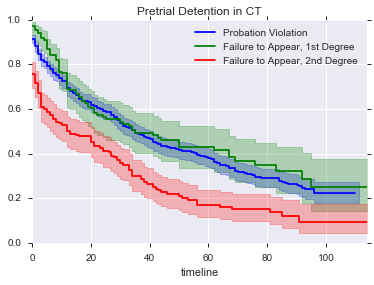

In [110]:
probviolation = (final['OFFENSE']=='VIOLATION OF PROBATION OR COND DISCHG')
failtoappear2 = (final['OFFENSE']=='FAILURE TO APPEAR, SECOND DEGREE      AM')
failtoappear1 = (final['OFFENSE']=='FAILURE TO APPEAR, FIRST DEGREE       DF')
ax = plt.subplot(111)

kmf.fit(T[probviolation], event_observed=C[probviolation], label = 'Probation Violation')
kmf.plot(ax=ax)
kmf.fit(T[failtoappear1], event_observed=C[failtoappear1], label = 'Failure to Appear, 1st Degree')
kmf.plot(ax=ax)
kmf.fit(T[failtoappear2], event_observed=C[failtoappear2], label = 'Failure to Appear, 2nd Degree')
kmf.plot(ax=ax)


plt.ylim(0,1);
plt.title('Pretrial Detention in CT')

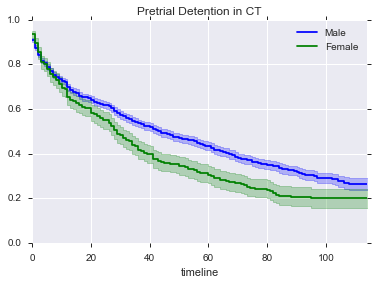

In [111]:
male = (final['GENDER']=='M')
female = (final['GENDER']=='F')
ax = plt.subplot(111)

kmf.fit(T[male], event_observed=C[male], label = 'Male')
kmf.plot(ax=ax)
kmf.fit(T[female], event_observed=C[female], label = 'Female')
kmf.plot(ax=ax)

plt.ylim(0,1);
plt.title('Pretrial Detention in CT')